<a href="https://colab.research.google.com/github/jai2shan/TSAI_END2/blob/main/Session%203/Session_3_Pytorch%2084%20Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision import datasets
datasets.MNIST('data', download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train

In [2]:

# import torch
# train = torch.load("/content/data/MNIST/processed/training.pt")
# randInt = torch.randint(0,9,(60000,))

# import torch
# from torch.utils.data import DataLoader

# class CustomLoader_MNIST(DataLoader):
#     def __init__(self,pt_path):
#         self.path = pt_path
#         self.data = torch.load(self.path)
        

#     def __getitem__(self, index):
#       print(self.data)
#       r = self.data.iloc[index]
#       randInt = torch.randint(0,9,(r.shape[0],))

#       image, label = r
#       output = torch.cat((label.reshape(len(label),-1),
#                           (label + randInt).reshape(len(label),-1)),
#                          dim = 1)
#       x = torch.empty(size=(len(randInt), 28,28))
#       for i in range(len(randInt)):
#           x[i] = randInt[i]*torch.ones(28,28)
          
#       input = torch.cat((image, x),dim = 1)
#       return output, input

#     def __len__(self):
#       return len(self.data)

# train_data = CustomLoader_MNIST("/content/data/MNIST/processed/training.pt")
# test_data = CustomLoader_MNIST("/content/data/MNIST/processed/test.pt")

In [3]:
import torch
train = torch.load("/content/data/MNIST/processed/training.pt")
randInt = torch.randint(0,9,(60000,))

import torch
from torch.utils.data import DataLoader

class CustomLoader_MNIST(DataLoader):
    def __init__(self,pt_path):
        self.path = pt_path
        self.data = torch.load(self.path)
        

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()

      image, label = self.data[0][idx], self.data[1][idx] 

      randInt = torch.randint(0,9,(1,))
      x1, x2, y1, y2 = image.reshape(1,28,28), randInt, label, label + randInt[0]

      return x1, x2, y1, y2

    def __len__(self):
      return len(self.data[0])

train_data = CustomLoader_MNIST("/content/data/MNIST/processed/training.pt")
test_data = CustomLoader_MNIST("/content/data/MNIST/processed/test.pt")

In [4]:
torch.manual_seed(1)
batch_size = 512
use_cuda = torch.cuda.is_available()

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, **kwargs)

In [5]:
from tqdm import tqdm
pbar = tqdm(train_loader)
device = torch.device("cuda" if use_cuda else "cpu")
for batch_idx, (x1, x2, y1, y2) in enumerate(pbar):
    x1, x2, y1, y2 = x1.to(device), x2.to(device), y1.to(device), y2.to(device)
    pbar.set_description(desc= f'batch_id={batch_idx}')

batch_id=117: 100%|██████████| 118/118 [00:04<00:00, 29.06it/s]


In [6]:
import torch.nn.functional as F
import torch.nn as nn
dropout_value = 0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)
        # self.relu = nn.ReLU()
        self.ln1 = nn.Linear(11,19)

    def forward(self, img, rnum):        
        img = self.convblock1(img)
        img = self.convblock2(img)
        img = self.convblock3(img)
        img = self.pool1(img)
        img = self.convblock4(img)
        img = self.convblock5(img)
        img = self.convblock6(img)
        img = self.convblock7(img)
        img = self.gap(img)        
        img = self.convblock8(img)
        
        img = img.view(-1, 10)
        rnum = torch.cat((img, rnum), dim=1)
        rnum = self.ln1(rnum)

        img = F.log_softmax(img, dim=-1)
        rnum = F.log_softmax(rnum, dim=-1)
        return img, rnum

In [7]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
# summary(model, input_size=((1, 28, 28),1))

cuda


In [8]:
from tqdm import tqdm

train_losses = []
test_losses =  []
train_acc =  {'Image': [], 'RandomNumber': []}
test_acc = {'Image': [], 'RandomNumber': []}


def train(model, device, train_loader, optimizer, epoch,loss1_,loss2_):

  model.train()
  pbar = tqdm(train_loader)
  correct1 = 0
  processed = 0
  correct2 = 0

  for batch_idx, (x1, x2, y1, y2) in enumerate(pbar):
    # Data
    x1, x2, y1, y2 = x1.float().to(device), x2.float().to(device), y1.to(device), y2.to(device)
    # Init
    
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict

    y1_pred, y2_pred = model(x1, x2)

    # Calculate loss
    loss1 = F.nll_loss(y1_pred, y1)
    loss2 = F.nll_loss(y2_pred, y2)

    # Cross Entropy Loss
    # loss1 = loss1_(y1_pred, y1)
    # loss2 = loss2_(y2_pred, y2)

    loss =  torch.add(loss1, loss2*2)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred1 = y1_pred.argmax(dim=1, keepdim=True)
    pred2 = y2_pred.argmax(dim=1, keepdim=True)
    
    # get the index of the max log-probability
    correct1 += pred1.eq(y1.view_as(pred1)).sum().item()
    correct2 += pred2.eq(y2.view_as(pred2)).sum().item()
    processed += len(x1)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy_digit={100*correct1/processed:0.2f} Accuracy_Rnum={100*correct2/processed:0.2f}')
    train_acc['Image'].append(100*correct1/processed)
    train_acc['RandomNumber'].append(100*correct2/processed)

def test(model, device, test_loader):
    model.eval()
    correct1 = 0
    correct2 = 0
    with torch.no_grad():
        for x1, x2, y1, y2 in test_loader:
            x1, x2, y1, y2 = x1.float().to(device), x2.float().to(device), y1.to(device), y2.to(device)
            y1_pred, y2_pred = model(x1, x2)
            
            pred1 = y1_pred.argmax(dim=1, keepdim=True)
            pred2 = y2_pred.argmax(dim=1, keepdim=True)
            correct1 += pred1.eq(y1.view_as(pred1)).sum().item()
            correct2 += pred2.eq(y2.view_as(pred2)).sum().item()

    print('Test set: Accuracy_digit={} Accuracy_Rnum={}'.format(100*correct1/len(test_loader.dataset),100*correct2/len(test_loader.dataset)))
    test_acc['Image'].append(100*correct1/len(test_loader.dataset))
    test_acc['RandomNumber'].append(100*correct2/len(test_loader.dataset))

In [9]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015,momentum=0.9)

loss1_ = nn.CrossEntropyLoss()
loss2_ = nn.CrossEntropyLoss()

EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,loss1_,loss2_)
    test(model, device, test_loader)

  0%|          | 0/118 [00:00<?, ?it/s]

EPOCH: 0


Loss=4.218231201171875 Batch_id=117 Accuracy_digit=66.98 Accuracy_Rnum=16.20: 100%|██████████| 118/118 [00:02<00:00, 46.87it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=93.0 Accuracy_Rnum=22.46
EPOCH: 1


Loss=3.5290517807006836 Batch_id=117 Accuracy_digit=95.44 Accuracy_Rnum=30.05: 100%|██████████| 118/118 [00:02<00:00, 47.26it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.17 Accuracy_Rnum=32.09
EPOCH: 2


Loss=3.420166254043579 Batch_id=117 Accuracy_digit=96.84 Accuracy_Rnum=36.77: 100%|██████████| 118/118 [00:02<00:00, 46.59it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.91 Accuracy_Rnum=37.46
EPOCH: 3


Loss=2.884521961212158 Batch_id=117 Accuracy_digit=97.38 Accuracy_Rnum=41.15: 100%|██████████| 118/118 [00:02<00:00, 48.25it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.86 Accuracy_Rnum=40.11
EPOCH: 4


Loss=2.591370105743408 Batch_id=117 Accuracy_digit=97.69 Accuracy_Rnum=43.88: 100%|██████████| 118/118 [00:02<00:00, 47.88it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.3 Accuracy_Rnum=41.91
EPOCH: 5


Loss=2.935178756713867 Batch_id=117 Accuracy_digit=97.93 Accuracy_Rnum=46.34: 100%|██████████| 118/118 [00:02<00:00, 45.59it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.56 Accuracy_Rnum=52.17
EPOCH: 6


Loss=2.9260871410369873 Batch_id=117 Accuracy_digit=97.99 Accuracy_Rnum=48.36: 100%|██████████| 118/118 [00:02<00:00, 45.47it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.67 Accuracy_Rnum=52.36
EPOCH: 7


Loss=2.685948133468628 Batch_id=117 Accuracy_digit=98.01 Accuracy_Rnum=50.37: 100%|██████████| 118/118 [00:02<00:00, 47.08it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.71 Accuracy_Rnum=51.11
EPOCH: 8


Loss=2.956557273864746 Batch_id=117 Accuracy_digit=98.21 Accuracy_Rnum=51.66: 100%|██████████| 118/118 [00:02<00:00, 46.98it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.72 Accuracy_Rnum=53.95
EPOCH: 9


Loss=2.4871392250061035 Batch_id=117 Accuracy_digit=98.20 Accuracy_Rnum=52.96: 100%|██████████| 118/118 [00:02<00:00, 46.04it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.74 Accuracy_Rnum=48.12
EPOCH: 10


Loss=2.2051756381988525 Batch_id=117 Accuracy_digit=98.39 Accuracy_Rnum=54.90: 100%|██████████| 118/118 [00:02<00:00, 47.77it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.81 Accuracy_Rnum=56.24
EPOCH: 11


Loss=2.6461760997772217 Batch_id=117 Accuracy_digit=98.46 Accuracy_Rnum=54.15: 100%|██████████| 118/118 [00:02<00:00, 46.63it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.74 Accuracy_Rnum=54.95
EPOCH: 12


Loss=2.65083909034729 Batch_id=117 Accuracy_digit=98.39 Accuracy_Rnum=56.32: 100%|██████████| 118/118 [00:02<00:00, 48.77it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.7 Accuracy_Rnum=54.19
EPOCH: 13


Loss=2.282661199569702 Batch_id=117 Accuracy_digit=98.38 Accuracy_Rnum=57.69: 100%|██████████| 118/118 [00:02<00:00, 46.50it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.67 Accuracy_Rnum=61.32
EPOCH: 14


Loss=2.202937364578247 Batch_id=117 Accuracy_digit=98.50 Accuracy_Rnum=59.19: 100%|██████████| 118/118 [00:02<00:00, 46.85it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.02 Accuracy_Rnum=61.26
EPOCH: 15


Loss=2.4438984394073486 Batch_id=117 Accuracy_digit=98.48 Accuracy_Rnum=59.18: 100%|██████████| 118/118 [00:02<00:00, 46.72it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.0 Accuracy_Rnum=67.68
EPOCH: 16


Loss=2.2642908096313477 Batch_id=117 Accuracy_digit=98.52 Accuracy_Rnum=60.88: 100%|██████████| 118/118 [00:02<00:00, 46.01it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.91 Accuracy_Rnum=65.03
EPOCH: 17


Loss=2.2809884548187256 Batch_id=117 Accuracy_digit=98.58 Accuracy_Rnum=60.49: 100%|██████████| 118/118 [00:02<00:00, 47.82it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.92 Accuracy_Rnum=57.45
EPOCH: 18


Loss=2.119157314300537 Batch_id=117 Accuracy_digit=98.55 Accuracy_Rnum=62.07: 100%|██████████| 118/118 [00:02<00:00, 47.60it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.58 Accuracy_Rnum=57.9
EPOCH: 19


Loss=2.0897979736328125 Batch_id=117 Accuracy_digit=98.57 Accuracy_Rnum=62.31: 100%|██████████| 118/118 [00:02<00:00, 45.88it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.05 Accuracy_Rnum=65.12
EPOCH: 20


Loss=2.2930922508239746 Batch_id=117 Accuracy_digit=98.66 Accuracy_Rnum=62.60: 100%|██████████| 118/118 [00:02<00:00, 45.97it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.03 Accuracy_Rnum=65.91
EPOCH: 21


Loss=2.225133180618286 Batch_id=117 Accuracy_digit=98.72 Accuracy_Rnum=63.39: 100%|██████████| 118/118 [00:02<00:00, 46.03it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.07 Accuracy_Rnum=63.83
EPOCH: 22


Loss=2.229485034942627 Batch_id=117 Accuracy_digit=98.64 Accuracy_Rnum=63.16: 100%|██████████| 118/118 [00:02<00:00, 46.56it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.02 Accuracy_Rnum=69.43
EPOCH: 23


Loss=1.8971221446990967 Batch_id=117 Accuracy_digit=98.70 Accuracy_Rnum=64.78: 100%|██████████| 118/118 [00:02<00:00, 46.29it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.1 Accuracy_Rnum=67.1
EPOCH: 24


Loss=2.1323845386505127 Batch_id=117 Accuracy_digit=98.79 Accuracy_Rnum=64.65: 100%|██████████| 118/118 [00:02<00:00, 48.15it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.99 Accuracy_Rnum=64.32
EPOCH: 25


Loss=2.090052366256714 Batch_id=117 Accuracy_digit=98.78 Accuracy_Rnum=64.13: 100%|██████████| 118/118 [00:02<00:00, 46.02it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.82 Accuracy_Rnum=70.46
EPOCH: 26


Loss=2.3580691814422607 Batch_id=117 Accuracy_digit=98.74 Accuracy_Rnum=65.58: 100%|██████████| 118/118 [00:02<00:00, 48.19it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.97 Accuracy_Rnum=67.14
EPOCH: 27


Loss=2.0914695262908936 Batch_id=117 Accuracy_digit=98.71 Accuracy_Rnum=64.69: 100%|██████████| 118/118 [00:02<00:00, 46.93it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.89 Accuracy_Rnum=72.68
EPOCH: 28


Loss=2.0933327674865723 Batch_id=117 Accuracy_digit=98.79 Accuracy_Rnum=66.36: 100%|██████████| 118/118 [00:02<00:00, 46.52it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.13 Accuracy_Rnum=64.48
EPOCH: 29


Loss=1.9529038667678833 Batch_id=117 Accuracy_digit=98.80 Accuracy_Rnum=67.98: 100%|██████████| 118/118 [00:02<00:00, 46.17it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.09 Accuracy_Rnum=66.95
EPOCH: 30


Loss=1.926681637763977 Batch_id=117 Accuracy_digit=98.79 Accuracy_Rnum=66.59: 100%|██████████| 118/118 [00:02<00:00, 46.59it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.83 Accuracy_Rnum=81.25
EPOCH: 31


Loss=1.9725759029388428 Batch_id=117 Accuracy_digit=98.81 Accuracy_Rnum=68.03: 100%|██████████| 118/118 [00:02<00:00, 46.08it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.85 Accuracy_Rnum=63.02
EPOCH: 32


Loss=1.870949149131775 Batch_id=117 Accuracy_digit=98.71 Accuracy_Rnum=68.88: 100%|██████████| 118/118 [00:02<00:00, 46.60it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.98 Accuracy_Rnum=74.87
EPOCH: 33


Loss=1.9254707098007202 Batch_id=117 Accuracy_digit=98.85 Accuracy_Rnum=68.76: 100%|██████████| 118/118 [00:02<00:00, 46.69it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.9 Accuracy_Rnum=74.1
EPOCH: 34


Loss=1.9352061748504639 Batch_id=117 Accuracy_digit=98.85 Accuracy_Rnum=69.63: 100%|██████████| 118/118 [00:02<00:00, 47.23it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.94 Accuracy_Rnum=72.66
EPOCH: 35


Loss=2.502619504928589 Batch_id=117 Accuracy_digit=98.81 Accuracy_Rnum=70.32: 100%|██████████| 118/118 [00:02<00:00, 45.81it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.89 Accuracy_Rnum=75.44
EPOCH: 36


Loss=1.8631136417388916 Batch_id=117 Accuracy_digit=98.88 Accuracy_Rnum=69.44: 100%|██████████| 118/118 [00:02<00:00, 46.58it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.12 Accuracy_Rnum=77.91
EPOCH: 37


Loss=2.3433711528778076 Batch_id=117 Accuracy_digit=98.94 Accuracy_Rnum=71.40: 100%|██████████| 118/118 [00:02<00:00, 44.75it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.23 Accuracy_Rnum=80.24
EPOCH: 38


Loss=1.6999471187591553 Batch_id=117 Accuracy_digit=98.88 Accuracy_Rnum=71.30: 100%|██████████| 118/118 [00:02<00:00, 46.17it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.08 Accuracy_Rnum=75.24
EPOCH: 39


Loss=1.9526349306106567 Batch_id=117 Accuracy_digit=98.88 Accuracy_Rnum=70.95: 100%|██████████| 118/118 [00:02<00:00, 46.37it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.0 Accuracy_Rnum=77.4
EPOCH: 40


Loss=1.716088056564331 Batch_id=117 Accuracy_digit=98.87 Accuracy_Rnum=71.99: 100%|██████████| 118/118 [00:02<00:00, 46.73it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.21 Accuracy_Rnum=64.75
EPOCH: 41


Loss=1.8929070234298706 Batch_id=117 Accuracy_digit=98.89 Accuracy_Rnum=71.12: 100%|██████████| 118/118 [00:02<00:00, 46.82it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.07 Accuracy_Rnum=73.1
EPOCH: 42


Loss=1.9172717332839966 Batch_id=117 Accuracy_digit=98.93 Accuracy_Rnum=70.90: 100%|██████████| 118/118 [00:02<00:00, 45.24it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.08 Accuracy_Rnum=76.04
EPOCH: 43


Loss=1.667397379875183 Batch_id=117 Accuracy_digit=98.94 Accuracy_Rnum=71.71: 100%|██████████| 118/118 [00:02<00:00, 46.87it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.12 Accuracy_Rnum=69.5
EPOCH: 44


Loss=1.9483164548873901 Batch_id=117 Accuracy_digit=98.91 Accuracy_Rnum=72.48: 100%|██████████| 118/118 [00:02<00:00, 46.40it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.17 Accuracy_Rnum=81.37
EPOCH: 45


Loss=1.636488437652588 Batch_id=117 Accuracy_digit=98.93 Accuracy_Rnum=72.53: 100%|██████████| 118/118 [00:02<00:00, 46.36it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.08 Accuracy_Rnum=81.26
EPOCH: 46


Loss=2.521821975708008 Batch_id=117 Accuracy_digit=98.95 Accuracy_Rnum=73.49: 100%|██████████| 118/118 [00:02<00:00, 45.92it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.98 Accuracy_Rnum=61.32
EPOCH: 47


Loss=1.626685380935669 Batch_id=117 Accuracy_digit=98.87 Accuracy_Rnum=70.80: 100%|██████████| 118/118 [00:02<00:00, 45.53it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.93 Accuracy_Rnum=77.95
EPOCH: 48


Loss=1.747693657875061 Batch_id=117 Accuracy_digit=98.94 Accuracy_Rnum=72.92: 100%|██████████| 118/118 [00:02<00:00, 45.75it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.0 Accuracy_Rnum=84.83
EPOCH: 49


Loss=1.7268768548965454 Batch_id=117 Accuracy_digit=98.93 Accuracy_Rnum=74.19: 100%|██████████| 118/118 [00:02<00:00, 45.73it/s]


Test set: Accuracy_digit=98.99 Accuracy_Rnum=83.98


Text(0.5, 1.0, 'Test - Random Number Model')

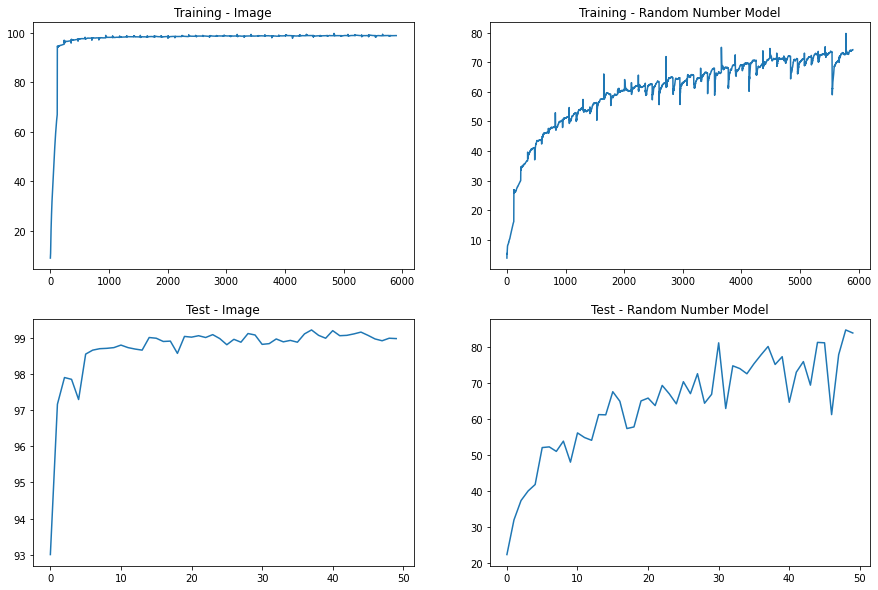

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_acc['Image'][:])
axs[0, 0].set_title("Training - Image")
axs[0, 1].plot(train_acc['RandomNumber'][:])
axs[0, 1].set_title("Training - Random Number Model")
axs[1, 0].plot(test_acc['Image'][:])
axs[1, 0].set_title("Test - Image")
axs[1, 1].plot(test_acc['RandomNumber'][:])
axs[1, 1].set_title("Test - Random Number Model")